<a href="https://colab.research.google.com/github/JaySeeDub/Coding-Dojo/blob/main/Exercises/06_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks

File name convention: For group 42 and memebers Richard Stallman and Linus <br> Torvalds it would be <br>
"06_Goup42_Stallman_Torvalds.pdf".

Submission via blackboard (UA).

Feel free to answer free text questions in text cells using markdown and <br>
possibly $\LaTeX{}$ if you want to.

**You don't have to understand every line of code here and it is not intended** <br> **for you to try to understand every line of code.**<br>
**Big blocks of code are usually meant to just be clicked through.**

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import torch
assert torch.__version__ >= "2.0"
from torch import nn
from torch.utils.data import DataLoader, Dataset

import keras

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
torch.manual_seed(42)
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Vanishing/Exploding Gradients Problem

Just like with SGD for linear regression, the fundamental procedure in simple <br>
neural networks is to **update model weights and biases** by taking some form of <br>
**partial derivative of a loss function** with respect to our weights and biases <br>
and then **stepping our weights** in the direction of the negative partial <br>
derivative.

By **chain rule**, that means that we'll also need to have some kind of <br>
**partial derivative of our activation function** with respect to our weights and <br>
biases. If the **slope of an activation function** has a tendency to **explode** or <br>
**vanish**, then our gradient might also explode or vanish which means we end up <br>
taking **steps in our weights** that are **too large** or **too small**.

### TASK 1: Sigmoid, Relu, Leaky Relu

In [54]:
def logit(z):
    return 1 / (1 + np.exp(-z))

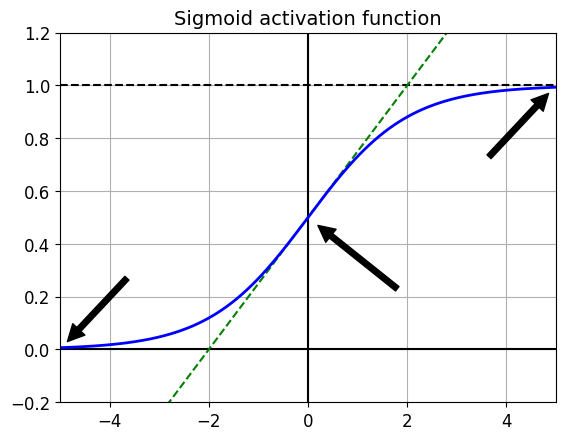

In [55]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

**Task 1 a)** Describe the sigmoid activation function in the three indicated <br>
regions in the above plot.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 1 a) answer:

The slope of the sigmoid is near zero at either end and 0.25 at the middle

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

### Leaky ReLU

**Task 1 b)** Write the [leaky relu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Leaky_ReLU) function as `def leaky_relu():`. <br>
It should take `z` as argument and also another optional argument `alpha` with <br> default value 0.01.<br>
The leaky relu function is defined to be `alpha*z` for z<0 and `z` for z>0.

(alterntively you can think about using `np.maximum` to make the distinction, <br> assuming alpha>0)

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [60]:
def leaky_relu(z, alpha=0.01):
  return np.where(z > 0, z, alpha*z)

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

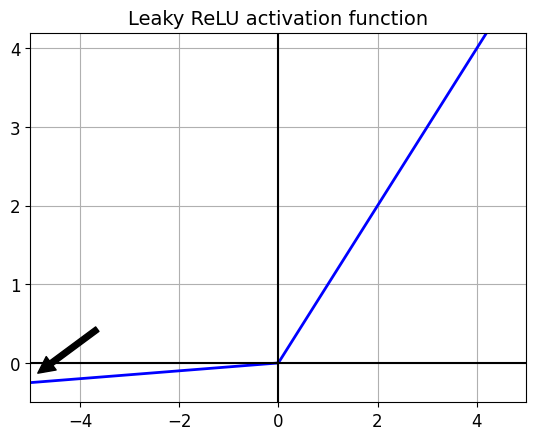

In [61]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

**Task 1c)** Describe the difference between relu and leaky relu?
Also explain why one might want to use leaky relu.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 1c) answer:

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

##### Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [ ]:
# load fashion MNIST + train_test split
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.copy()).float()
        self.y = torch.from_numpy(y.copy()).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_data = ClassificationDataset(X_train, y_train)
valid_data = ClassificationDataset(X_valid, y_valid)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False)

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

model = torch.nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 10),
)

In [ ]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': []
    }  # Initialize a dictionary to store epoch-wise results

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            y = y.to(proper_dtype)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()
            epoch_metric += metric(outputs, y)

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                y_val = y_val.to(proper_dtype)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                val_metric += metric(outputs_val, y_val)

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

    return history, model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [ ]:
history, model = train_and_validate(train_loader, valid_loader, model,
                                    optimizer=optimizer, criterion=criterion,
                                    num_epochs=10, metric=accuracy_metric)

### TASK 2: ELU
**Task 2 a)** Describe the [ELU activation](https://paperswithcode.com/method/elu) function and compare to LeakyRelu. <br>
The definition is described in Chapter 11 or alternatively at the above link.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 2 a) answer:

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

**Task 2 b)** Similar to `leaky_relu` above, write the function `def elu():` as <br> a function of z with optional argument `alpha=1` (meaning that the default <br> value is 1).

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.annotate('', xytext=(-3.5, 0), xy=(-4, -1), arrowprops=props, fontsize=14, ha="center")
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

To use the elu activation function in TensorFlow you need to specify the <Br> activation function when building each layer (Check on the [Pytorch Website](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)
<br>
for some examples): <br>
`nn.ELU()`

**Task 2 c)** Using the same layer dimensions from the previous model <br> (LeakyRelu), train with ELU activation instead.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [ ]:
# model = ...

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [ ]:
history, model = train_and_validate(train_loader, valid_loader, model,
                                    optimizer=optimizer, criterion=criterion,
                                    num_epochs=1, metric=accuracy_metric)

## Task 3: Batch Normalization
**Task 3 a)** Build a NN with two hidden layers with 300 and 100 nodes. Use <br>
RELU as activation function. Add [Batch Normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) layers before each <br>
dense layer (check the definition in Chapter 11)   

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    # ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

    # ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
    nn.Linear(10),
)

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [ ]:
history, model = train_and_validate(train_loader, valid_loader, model,
                                    optimizer=optimizer, criterion=criterion,
                                    num_epochs=25, metric=accuracy_metric)

In [ ]:
print(model)

**Task 3 b)** Explain what batch normalization does and discuss the results of above training.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 3b) answer:

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

## Task 4: Reusing a Pytorch model

Let's split the fashion MNIST training set in two: <br>
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).<br>
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without <br>
restricting the number of images.

**We will train a model on set A (classification task with 8 classes), and try to** <br>
**reuse it to tackle set B (binary classification).** We hope to transfer a little <br>
bit of knowledge from task A to task B, since classes in set A (sneakers, <br>
ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B <br>
(sandals and shirts). However, **since we are using `Dense` layers, only patterns** <br>
**that occur at the same location can be reused** (in contrast, **convolutional <br> layers will transfer much better**, since learned patterns can be detected <br>
anywhere on the image, as we will see in the CNN chapter).

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.copy()).float()
        self.y = torch.from_numpy(y.copy()).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_data = ClassificationDataset(X_train_A, y_train_A)
valid_data = ClassificationDataset(X_valid_A, y_valid_A)
test_data = ClassificationDataset(X_test_A, y_test_A)

train_loader_A = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader_A = DataLoader(test_data, batch_size=64, shuffle=False)
valid_loader_A = DataLoader(valid_data, batch_size=64, shuffle=False)

In [ ]:
train_data = ClassificationDataset(X_train_B, y_train_B)
valid_data = ClassificationDataset(X_valid_B, y_valid_B)
test_data = ClassificationDataset(X_test_B, y_test_B)

train_loader_B = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader_B = DataLoader(test_data, batch_size=64, shuffle=False)
valid_loader_B = DataLoader(valid_data, batch_size=64, shuffle=False)

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
model_A = nn.Sequential()
model_A.append(nn.Flatten())
n_last = 28*28
for n_hidden in (300, 100, 50, 50, 50):
    model_A.append(nn.Linear(n_last, n_hidden))
    model_A.append(nn.SELU())
    n_last = n_hidden
model_A.append(nn.Linear(n_last, 8))

In [ ]:
criterion_A = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_A.parameters(), lr=0.001)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [ ]:
history_A, model_A = train_and_validate(train_loader_A, valid_loader_A, model_A,
                                        optimizer=optimizer, criterion=criterion_A,
                                        num_epochs=30, metric=accuracy_metric)

In [ ]:
model_B = nn.Sequential()
model_B.append(nn.Flatten())
n_last = 28*28
for n_hidden in (300, 100, 50, 50, 50):
    model_B.append(nn.Linear(n_last, n_hidden))
    model_B.append(nn.SELU())
    n_last = n_hidden
model_B.append(nn.Linear(n_last, 1))
model_B.append(nn.Sigmoid())
model_B.append(nn.Flatten(start_dim=0))

In [ ]:
criterion_B = nn.BCELoss()
optimizer = torch.optim.SGD(model_B.parameters(), lr=0.001)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [ ]:
history_B, model_B = train_and_validate(train_loader_B, valid_loader_B, model_B,
                                        optimizer=optimizer, criterion=criterion_B,
                                        num_epochs=30, metric=accuracy_metric)

In [ ]:
model_B_on_A = nn.Sequential()
for module in list(model_A.modules())[1:]:
    model_B_on_A.append(module)
model_B_on_A.append(nn.Linear(8, 1))
model_B_on_A.append(nn.Sigmoid())
model_B_on_A.append(nn.Flatten(start_dim=0))

Note that `model_B_on_A` and `model_A` actually share layers now, so **when we** <br>
**train one, it will update both models**. If we want **to avoid that**, we need to <br>
**build `model_B_on_A` on top of a clone of `model_A`**:

In [ ]:
import copy

In [ ]:
model_A_clone = copy.deepcopy(model_A)
model_A_clone.load_state_dict(model_A.state_dict())

In [ ]:
for param in model_B_on_A.parameters():
    param.requires_grad = False

In [ ]:
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.001)

In [ ]:
for param in model_B_on_A.parameters():
    param.requires_grad = True

history_B_on_A, model_B_on_A = train_and_validate(train_loader_B, valid_loader_B, model_B_on_A,
                                                  optimizer=optimizer, criterion=criterion_B,
                                                  num_epochs=30, metric=accuracy_metric)

Task 4:
a) Evaluate the loss and accuracy of the two models `model_B` and <br> `model_B_on_A` on the sandals/shirts dataset.

In [ ]:
def test_model(model, data_loader, criterion, metric=None):
    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0  # Initialize the total loss and metric values
    total_metric = 0.0

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")


    with torch.no_grad():  # Disable gradient tracking
        for batch in data_loader:
            X, y = batch
            y = y.to(proper_dtype)
            # Pass the data to the model and make predictions
            outputs = model(X)

            # Compute the loss
            loss = criterion(outputs, y)

            # Add the loss and metric for the batch to the total values
            total_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                total_metric += metric(outputs, y)
            else:
                total_metric += 0.0

    # Average loss and metric for the entire dataset
    avg_loss = total_loss / len(data_loader)
    avg_metric = total_metric / len(data_loader)

    print(f'Test Loss: {avg_loss:.4f}, Test Metric: {avg_metric:.4f}')

    return avg_loss, avg_metric

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

b) In your own words, explain above "transfer learning". Did it help?

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

## Task 5: Learning Rate Scheduling

Just like when we learned about SGD for linear regression, **decreasing the** <br>
**learning rate over time can improve convergence**. One way to do this is to write <br>
a schedule to decay the learning rate as a function of epoch number.

Let's add a an exponential decay of the learning rate:

We will use the following learning rate schedule (exponential):   
$ lr = lr_0 \cdot 0.1 ^ {epoch / 20}$

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

**Note: If you want to use learning rate decay, it is probably better to use a** <br>
**Pytorch built-in function like [ExponentialLR](hhttps://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR) and not program it yourself.**

In order to make our training loop more flexible, we'll add **default values** of <br>
`None` for the **metric** and **scheduler**. Depending on the task, we might not <br>
always need or want to use a metric or scheduler but this will be our new <br>
train and validation loop. We've also added **learning rate tracking** to our <br>
model history output.

In [ ]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            y = y.to(proper_dtype)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                y_val = y_val.to(proper_dtype)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, y_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        # THESE LINES ARE NEW AND ACCOUNT FOR SCHEDULERS
        if scheduler is not None:
            scheduler.step()

    return history, model

**Task 5:**
- Build a NN with: two hidden layers with 300 and 100 nodes, add <br>
Batch Normalization layers before the linear layers,
- Train the model with `nn.CrossEntropyLoss()` as `criterion`, <br> `scheduler` and `optimizer` provided above and `accuracy` as the `metric`, <br>
- Fit the model to `train_loader` for 25 epochs. Use `valid_loader` for the <br>
validation data.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [ ]:
#model =

#optimizer = torch.optim.NAdam(model.parameters())
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, exponential_decay_fn)

In [ ]:
#history, model =

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

Let's check out our model performance with a test loop.

In [ ]:
def test_model(model, data_loader, criterion, metric=None):
    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0  # Initialize the total loss and metric values
    total_metric = 0.0

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")


    with torch.no_grad():  # Disable gradient tracking
        for batch in data_loader:
            X, y = batch
            y = y.to(proper_dtype)
            # Pass the data to the model and make predictions
            outputs = model(X)

            # Compute the loss
            loss = criterion(outputs, y)

            # Add the loss and metric for the batch to the total values
            total_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                total_metric += metric(outputs, y)
            else:
                total_metric += 0.0

    # Average loss and metric for the entire dataset
    avg_loss = total_loss / len(data_loader)
    avg_metric = total_metric / len(data_loader)

    print(f'Test Loss: {avg_loss:.4f}, Test Metric: {avg_metric:.4f}')

    return avg_loss, avg_metric

In [ ]:
# note that the model is overfitting a lot. Might want to use dropout
# also a CNN will perform much better as we will see next Hands-On
print("train loss:", test_model(model, train_loader, nn.CrossEntropyLoss())[0])
print("test loss:", test_model(model, test_loader, nn.CrossEntropyLoss())[0])

In [ ]:
# the learning rate is saved in the history under the key 'learning_rate'
print(history.keys())

In [ ]:
plt.plot(history['epoch'], history["learning_rate"], "o-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Task 6: Performance Scheduling

Because **Loss vs. weight spaces are generally not globally convex-up**, it's <br>
likely that your model will get stuck in a **local minimum loss**. When that <br>
happens, it can mean that your **learning rate is** so **low** that it's unable to push <br>
your model weights outside of the local minimum region. We can try to **increase** <br>
**the learning rate** in that case **to escape a local minimum**. This is like pushing <br>
a ball further up the side of a valley in the hopes that it eventually rolls <br>
over a cliff and down into a deeper valley when you get to the top.

For performance scheduling, use the `ReduceLROnPlateau` scheduler. Example: <br>
if you step the following learning rate scheduler it will step the learning <br>
rate by 0.5 whenever the best validation loss does not improve for two <br>
consecutive epochs:

`scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(factor=0.5, patience=2)`

**You will need to update the `scheduler.step()` portion of the  train_and_validate** <br>
loop for `ReduceLROnPlateau`. Refer to the example at the bottom of [this page](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau). <br>
This is due to the fact that this optimizer has a patience argument that will <br>
check a certain quantity to decide whether it's time to step.


In [ ]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            y = y.to(proper_dtype)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                y_val = y_val.to(proper_dtype)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, y_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        if scheduler is not None:
            # MODIFY THIS LINE TO WORK PROPERLY FOR REDUCELRONPLATEAU
            scheduler.step(  # This will crash if you don't fix it

    return history, model

**Task 6:**   
a) Re-use (copy-paste) the NN from Task 5: two hidden layers with 300 and 100 <br>
nodes and Batch Normalization layers before the linear layers. But, now use Adam <br> optimizer with a initial lr=0.01 and ReduceLROnPlateau scheduler.<br>
b) Compare the results with the previous one (Task 5), <br>
c) Comment on the learning rate as a function of epochs using the plot given <br>below.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [ ]:
plt.plot(history['epoch'], history["learning_rate"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history['epoch'], history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 6 c) answer:

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

## Task 7 Avoiding Overfitting Through Regularization

A **dropout layer** essentially **takes all inputs** passed to it and randomly **sets** <br>
**some inputs to 0** with a certain rate. One way that models can **overfit** to <br>
training data is by essentially *"memorizing"* or encoding into its function some <br>
**properties that are specific to one data set**.

We can help mitigate this by ensuring our data is as **non-homogeneous within** <br>
**each sample** (train, val, test) and as **homogeneous across our samples as** <br>
**possible**. This isn't always enough as we often end up showing our model the <br>
same training data multiple times and **it may learn patterns about the training** <br>
**data that don't exist in other data**.

By adding dropout, we **decrease the likelihood that it learns** these sorts of <br>
**inter-sample patterns by adding random variations** to either the data or the way <br>
it handles the same data each time.

Our models above all overfit (why?). Let's now tackle this problem using <br> dropout.

**Task 7:**   
a) Copy the code for the model of Task 6, add a dropout (20% rate) before each <br> hidden layer (https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) <br>
b) Compare the results.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

In [ ]:
print("train loss:", test_model(model, train_loader, nn.CrossEntropyLoss())[0])
print("test loss:", test_model(model, test_loader, nn.CrossEntropyLoss())[0])

In [ ]:
plt.plot(history['epoch'], history["learning_rate"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history['epoch'], history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

# Optional Exercise (Bonus points): Using Callbacks during Training

**Task 8:** Add two of the following features to your model training loop:<br>
a) Keep track of the model with the best validation loss and return the best <br>
model at the end of the traininig loop instead of the last model.<br>
b) Stop model training after 5 epochs of loss not impoving <br>
c) Add [Tensorboard logging](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) for one or more quantities from your model <br> training history

You can use the code snippets below.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            y = y.to(proper_dtype)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                y_val = y_val.to(proper_dtype)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, y_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        if scheduler is not None:
            # MODIFY THIS LINE TO WORK PROPERLY FOR REDUCELRONPLATEAU
            scheduler.step(  # This will crash if you don't fix it

    return history, model

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [ ]:
history, model = train_and_validate(train_loader, valid_loader, model,
                                    optimizer=optimizer, criterion=criterion,
                                    num_epochs=50, metric=accuracy_metric)

In [ ]:
writer.flush()

In [ ]:
writer.close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./runs --port=6006

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above